# Cart Pole Control Problem<br>
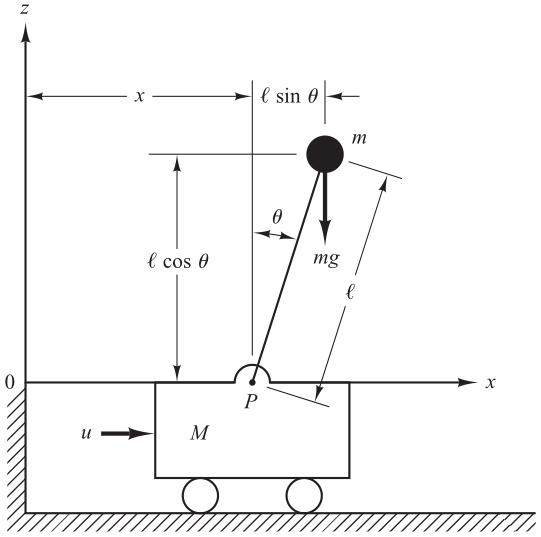
<br>
Define state variables as follows.
$x=\left[ x_1,x_2,x_3,x_4     \right]^T = \left[ \theta,\dot{\theta}, x,\dot{x}     \right]^T$ 
<br><br>
Using Euler-Lagrange's method, we can get the following equations of motion.<br>
$ml^2 \ddot{\theta}+ml\ddot{x} \cos\theta -mgl \sin \theta=0$ <br>
$ml\ddot{\theta} \cos \theta +(M+m)\ddot{x}-ml{\dot{\theta}}^2 \sin \theta=u$
<br><br>
By linearizing the EOMs around $\theta=0$, we have the following linear equations.<br>
$ml^2 \ddot{\theta}+ml\ddot{x} -mgl \theta=0$ <br>
$ml\ddot{\theta} +(M+m)\ddot{x}=u$
<br><br>
Finally, we will have the following state space model.<br>
$
\begin{bmatrix}
    \dot{x}_1 \\
    \dot{x}_2 \\
    \dot{x}_3 \\
    \dot{x}_4
\end{bmatrix}
=
\begin{bmatrix}
    0 & 1 & 0 & 0 \\
    \frac{m+M}{Ml}g & 0 & 0 & 0\\
    0 & 0 & 0 & 1 \\
    -\frac{m}{M}g & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
    x_1 \\
    x_2 \\
    x_3 \\
    x_4
\end{bmatrix}
+
\begin{bmatrix}
    0 \\
    -\frac{1}{Ml} \\
    0 \\
    \frac{1}{M}
\end{bmatrix}
u
=Ax+Bu
$
<br><br>
Consider the following initial condition and perform a simulation for 10 sec.<br>
$x_0=\left[ 0.1,0,0,0\right]   $

In [1]:
using ControlSystems;
using DifferentialEquations;
using PyPlot;
using Polynomials;

First, define the $\left(A,B,C,D \right)$  matrices for the system.<br>
You can perform analysis.<br>
stability<br>
controllability<br>
observability<br>

In [2]:
M=2;m=0.1;l=0.5;g=9.81;
A=[0 1 0 0;(m+M)/M/l*g 0 0 0;0 0 0 1;-m*g/M 0 0 0];
B=[0;-1/M/l;0;1/M];
C=[1.0 0 0 0];
D=0.0;
sys=ss(A,B,C,D,0);

In [3]:
eigvals(A)

4-element Array{Float64,1}:
  0.0    
  0.0    
  4.53883
 -4.53883

In [4]:
rank(ctrb(sys))

4

In [5]:
rank(obsv(sys))

2

# You can use "lsim" function to perform simulation for a linear system.

In [6]:
u(x,t)=[0.0 0.0 0.0 0.0]*x;
x0=[0.1;0.0;0.0;0.0];
tspan=0:0.01:10;
y, t, x, uout = lsim(sys,u,tspan,x0=x0);

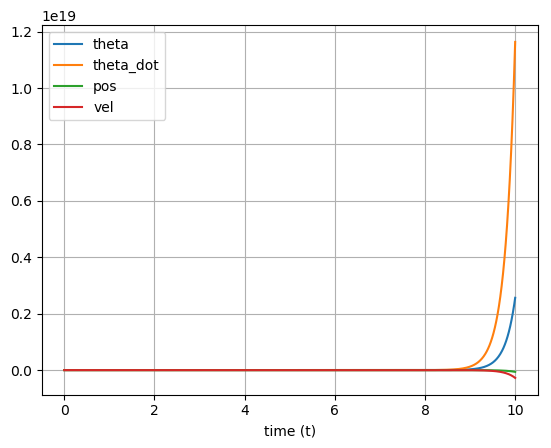

In [7]:
plot(t,x[:,1],label="theta")
plot(t,x[:,2],label="theta_dot")
plot(t,x[:,3],label="pos")
plot(t,x[:,4],label="vel")
xlabel("time (t)")
legend()
grid(true)

# Or, you can directly perform a numerical simulation

In [8]:
mutable struct Param
    A::Array{Float64,2}
    B::Array{Float64,1}
    C::Array{Float64,2}
    D::Float64
    K::Array{Float64,2}
    L::Array{Float64,2}
end

In [10]:
K=[0.0 0.0 0.0 0.0];
L=[0.0 0.0;0.0 0.0;0.0 0.0;0.0 0.0];
param= Param(A,B,C,D,K,L);

In [11]:
function f!(dx,x,param,t)
    A=param.A;
    B=param.B;
    u=0.0;
    temp=A*x+B*u;
#     make sure that you assign to each element
    dx[1]=temp[1];
    dx[2]=temp[2];
    dx[3]=temp[3];
    dx[4]=temp[4];

end;

In [12]:
prob=ODEProblem(f!,x0,(0.0,10.0),param);
sol=solve(prob,Tsit5(),dtmax=0.01);

In [13]:
n=length(sol.t);
theta=zeros(n); [theta[i]=sol.u[i][1] for i=1:n];
theta_dot=zeros(n); [theta_dot[i]=sol.u[i][2] for i=1:n];
pos=zeros(n); [pos[i]=sol.u[i][3] for i=1:n];
vel=zeros(n); [vel[i]=sol.u[i][4] for i=1:n];

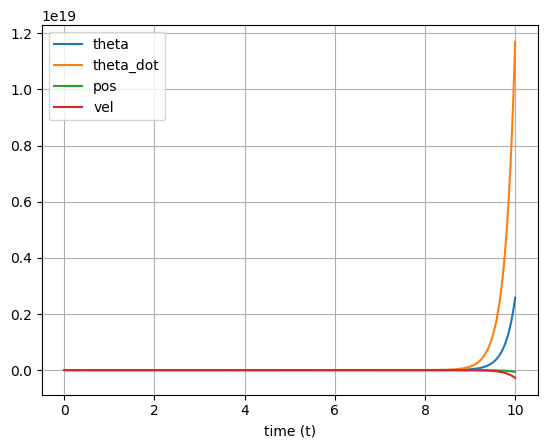

In [14]:
plot(sol.t,theta,label="theta")
plot(sol.t,theta_dot,label="theta_dot")
plot(sol.t,pos,label="pos")
plot(sol.t,vel,label="vel")
xlabel("time (t)")
legend()
grid(true)

# Now, let's design a controller.<br>
Since we had controllability, but unstable system, we can design a controller that can stabilize the system.
$\dot{x}=Ax+Bu$ and $u=-Kx$. <br>
Therefore, we will have $\dot{x}=(A-BK)x$<br>
Let's assume the desired pole location to be at $-2,-3,-4,-5$.

In [17]:
v1=nullspace([-2*eye(4)-sys.A sys.B]);
v2=nullspace([-3*eye(4)-sys.A sys.B]);
v3=nullspace([-4*eye(4)-sys.A sys.B]);
v4=nullspace([-5*eye(4)-sys.A sys.B]);

In [18]:
K=[v1[5,1] v2[5,1] v3[5,1] v4[5,1]]*inv([v1[1:4,1] v2[1:4,1] v3[1:4,1] v4[1:4,1]])

1×4 Array{Float64,2}:
 -97.7172  -21.8491  -12.2324  -15.6983

In [20]:
sys_new=sys.A-sys.B*K

4×4 Array{Float64,2}:
   0.0       1.0       0.0        0.0    
 -77.1162  -21.8491  -12.2324   -15.6983 
   0.0       0.0       0.0        1.0    
  48.3681   10.9246    6.11621    7.84913

In [21]:
eigvals(sys_new)

4-element Array{Float64,1}:
 -5.0
 -4.0
 -3.0
 -2.0

You can also use the built-in function "place". Note that you need to modify the synthesis.jl file to make the index of poly in Acker function to be based on 0-index.

In [22]:
K1=place(sys,[-2,-3,-4,-5])

1×4 Array{Float64,2}:
 -97.7172  -21.8491  -12.2324  -15.6983

# Now, apply the control and perform simulation

In [23]:
u(x,t)=-K*x;
y, t, x, uout = lsim(sys,u,tspan,x0=x0);

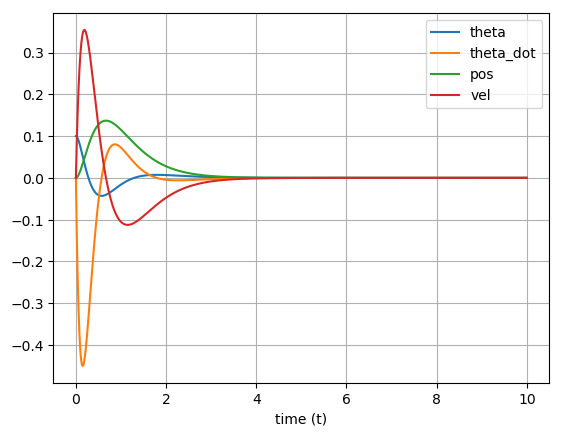

In [24]:
plot(t,x[:,1],label="theta")
plot(t,x[:,2],label="theta_dot")
plot(t,x[:,3],label="pos")
plot(t,x[:,4],label="vel")
xlabel("time (t)")
legend()
grid(true)

# Now, let's consider output feedback<br>
$u=-Ky=-KCx$<br>
The original $\left( A,C \right)$ matrix is unobservable.<br>
How about thie following?<br>
$
C=
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
\end{bmatrix}
$
<br>
It's easy to see that $\left(A,C \right)$ is observable.

In [25]:
C=[1.0 0 0 0;0.0 0 1 0]
rank(obsv(sys.A,C))

4

However, we have some issues.<br>
From above, we found that $K=\left[-97.7172  -21.8491  -12.2324  -15.6983\right]$<br>
In output feedback, we will have the following. <br>
$\left[-97.7172  -21.8491  -12.2324  -15.6983\right]=KC=\left[ k_1 k_2 \right]
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
\end{bmatrix}
$<br><br>
By taking the transpose, we have the following<br>
$
\begin{bmatrix}
    1 & 0 \\
    0 & 0 \\
    0 & 1 \\
    0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
    k_1  \\
    k_2  \\
\end{bmatrix}
=
\begin{bmatrix}
    -97.7172 \\
    -21.8491 \\
    -12.2324 \\
    -15.6983\\
\end{bmatrix}
$
<br><br>
As you may notice, you cannot find the exact solution. In this case, you need to increase the number of measurements.<br><br>
# Now, let's consider the observer.

In [97]:
function f!(dx,x,param,t)
    A=param.A;
    B=param.B;
    K=param.K;
    L=param.L;
    
    xtrue=x[1:4];
    xhat=x[5:8];
    u=-K*xhat;
    
    # observer    
    temp_hat=A*xhat+B*u[1]+L*C*(xhat-xtrue);
    
    dx[5]=temp_hat[1];
    dx[6]=temp_hat[2];
    dx[7]=temp_hat[3];
    dx[8]=temp_hat[4];
    
    # true physical system
    temp_true=A*xtrue+B*u[1];  

    dx[1]=temp_true[1];
    dx[2]=temp_true[2];
    dx[3]=temp_true[3];
    dx[4]=temp_true[4];

end;

In [201]:
v1=nullspace([-2*eye(4)-A' C'])
v2=nullspace([-3*eye(4)-A' C'])
v3=nullspace([-4*eye(4)-A' C'])
v4=nullspace([-5*eye(4)-A' C'])

L=[v1[5:6,1] v2[5:6,1] v3[5:6,1] v4[5:6,1]]*inv( [v1[1:4,1] v2[1:4,1] v3[1:4,1] v4[1:4,1]]);
L=L';
eigvals(A-L*C)

4-element Array{Float64,1}:
 -2.0
 -3.0
 -5.0
 -4.0

In [194]:
# L=place(A',C',[-10,-11,-12,-13])
# L=[22.9338 1.0388;151.3808 11.9770;0.9570 23.0662;10.4925 132.2187];
param.C=C;
param.K=K;
param.L=-L;

For your information, the command "place" is using a method called "ackermann" method. ackermann method works only for single input case. If we have multiple inputs, we will not have a unique K, but we will have some freedom to choose K. One possible way of finding K with multiple inputs is to maximize the stability margin. In Matlab, "place" is used. However, in Julia, it is not implemented yet.

In [195]:
x0=[0.1,0.0,0.0,0.0,0.5,0.5,0.5,0.5];
prob=ODEProblem(f!,x0,(0.0,10.0),param);
sol=solve(prob,Tsit5(),dtmax=0.01);

In [196]:
n=length(sol.t);
theta=zeros(n); [theta[i]=sol.u[i][1] for i=1:n];
theta_dot=zeros(n); [theta_dot[i]=sol.u[i][2] for i=1:n];
pos=zeros(n); [pos[i]=sol.u[i][3] for i=1:n];
vel=zeros(n); [vel[i]=sol.u[i][4] for i=1:n];
theta_hat=zeros(n); [theta_hat[i]=sol.u[i][5] for i=1:n];
theta_dot_hat=zeros(n); [theta_dot_hat[i]=sol.u[i][6] for i=1:n];
pos_hat=zeros(n); [pos_hat[i]=sol.u[i][7] for i=1:n];
vel_hat=zeros(n); [vel_hat[i]=sol.u[i][8] for i=1:n];

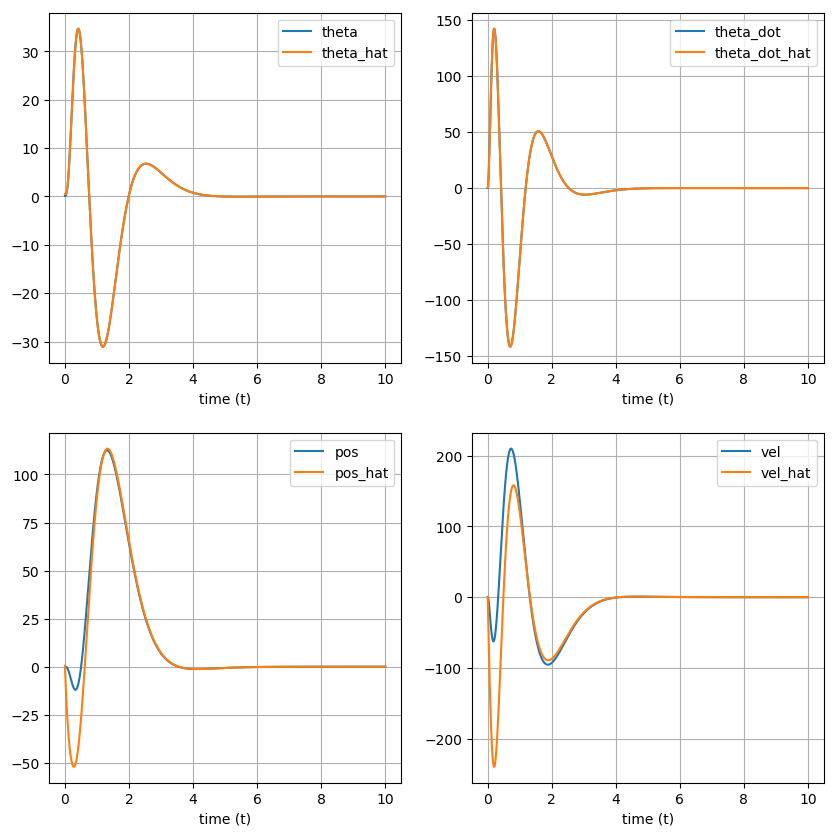

In [197]:
figure(figsize=(10,10))
subplot(221)
plot(sol.t,theta,label="theta")
plot(sol.t,theta_hat,label="theta_hat")
xlabel("time (t)")
legend()
grid(true)
subplot(222)
plot(sol.t,theta_dot,label="theta_dot")
plot(sol.t,theta_dot_hat,label="theta_dot_hat")
xlabel("time (t)")
legend()
grid(true)
subplot(223)
plot(sol.t,pos,label="pos")
plot(sol.t,pos_hat,label="pos_hat")
xlabel("time (t)")
legend()
grid(true)
subplot(224)
plot(sol.t,vel,label="vel")
plot(sol.t,vel_hat,label="vel_hat")
xlabel("time (t)")
legend()
grid(true)

In [198]:
# place(A',C',[-10,-15,-20,-25])
L=[7.7024 -0.7207;34.5649 -2.5235;-0.7029 6.2976;-2.9390 9.0361];     
param.L=-L;

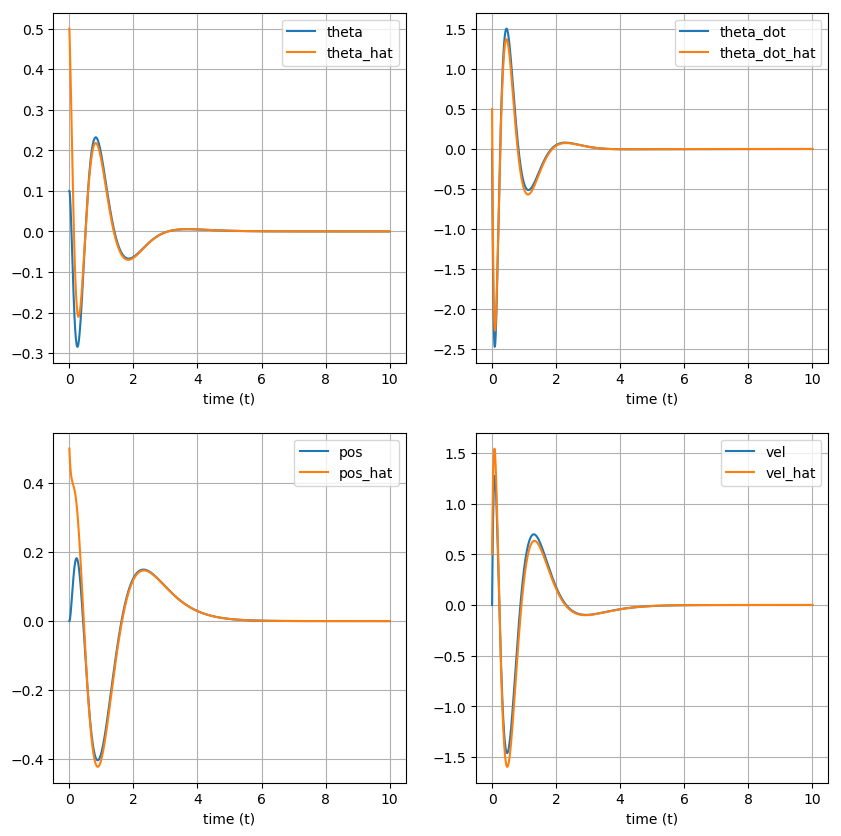

In [199]:
prob=ODEProblem(f!,x0,(0.0,10.0),param);
sol=solve(prob,Tsit5(),dtmax=0.01);

n=length(sol.t);
theta=zeros(n); [theta[i]=sol.u[i][1] for i=1:n];
theta_dot=zeros(n); [theta_dot[i]=sol.u[i][2] for i=1:n];
pos=zeros(n); [pos[i]=sol.u[i][3] for i=1:n];
vel=zeros(n); [vel[i]=sol.u[i][4] for i=1:n];
theta_hat=zeros(n); [theta_hat[i]=sol.u[i][5] for i=1:n];
theta_dot_hat=zeros(n); [theta_dot_hat[i]=sol.u[i][6] for i=1:n];
pos_hat=zeros(n); [pos_hat[i]=sol.u[i][7] for i=1:n];
vel_hat=zeros(n); [vel_hat[i]=sol.u[i][8] for i=1:n];

figure(figsize=(10,10))
subplot(221)
plot(sol.t,theta,label="theta")
plot(sol.t,theta_hat,label="theta_hat")
xlabel("time (t)")
legend()
grid(true)
subplot(222)
plot(sol.t,theta_dot,label="theta_dot")
plot(sol.t,theta_dot_hat,label="theta_dot_hat")
xlabel("time (t)")
legend()
grid(true)
subplot(223)
plot(sol.t,pos,label="pos")
plot(sol.t,pos_hat,label="pos_hat")
xlabel("time (t)")
legend()
grid(true)
subplot(224)
plot(sol.t,vel,label="vel")
plot(sol.t,vel_hat,label="vel_hat")
xlabel("time (t)")
legend()
grid(true)